### Data

In [1]:
plt.style.use('bmh')

df = pd.read_pickle('data/df.pkl')
df['ts_season'] = df['ts_season'].str[:1].astype(int)

print(df.shape)
df[:3]

(323410, 49)


,pkId,fkLinkSerialId,timestamp,speed,heading,msla,lat,long,tsReceived,dt,sunrise,sunset,temperature,feels_like,pressure,humidity,clouds,visibility,wind_speed,wind_gust,wind_deg,rain,snow,weatherid,place_type,accuracy,place_name,text,place,region,locality,neighborhood,postcode,country,timestamp_day,timestamp_month,ts_month,ts_hour,ts_season,ts_daypart,target_humidity,target_temperature,target_humidity_cat,target_temperature_cat,target_cat,lat_int,long_int,geo_group,fold
8125,2603778,0X0004BFD036AA,2022-05-09 00:50:19,0,0,70,45.60,-73.62,2022-05-09 00:50:19,2022-05-09 00:50:19,2022-05-09 05:31:00,2022-05-09 20:10:51,9.45,7.52,1025,38,0,10000,3.60,0.00,20,0.00,0.00,800,address,rooftop,"10889 Avenue Arthur-Buies, Montréal, Quebec H1...",Avenue Arthur-Buies,Montréal,CA-QC,NaN,Montréal-Nord,H1G 6N3,ca,2022-05-09,2022-05,5,0,2,1_night,NaN,NaN,NaN,NaN,NaN,45,-73,3.east,2
8127,2603780,0X0004BFD036AA,2022-05-09 00:50:37,0,0,62,45.60,-73.62,2022-05-09 00:50:37,2022-05-09 00:50:19,2022-05-09 05:31:00,2022-05-09 20:10:51,9.45,7.52,1025,38,0,10000,3.60,0.00,20,0.00,0.00,800,address,rooftop,"5730 Boulevard Industriel, Montréal, Quebec H1...",Boulevard Industriel,Montréal,CA-QC,NaN,Montréal-Nord,H1G 4N6,ca,2022-05-09,2022-05,5,0,2,1_night,NaN,NaN,NaN,NaN,NaN,45,-73,3.east,1
8129,2603782,0X0004BFD036AA,2022-05-09 00:50:55,0,0,59,45.60,-73.62,2022-05-09 00:50:55,2022-05-09 00:50:19,2022-05-09 05:31:00,2022-05-09 20:10:51,9.45,7.52,1025,38,0,10000,3.60,0.00,20,0.00,0.00,800,address,rooftop,"5727 Boulevard Industriel, Montréal, Quebec H1...",Boulevard Industriel,Montréal,CA-QC,NaN,Montréal-Nord,H1G 4N6,ca,2022-05-09,2022-05,5,0,2,1_night,NaN,NaN,NaN,NaN,NaN,45,-73,3.east,0


In [2]:
df_ag = df.groupby('fkLinkSerialId').target_temperature.agg([len, lambda x: x.count()])
df_ag.columns = ['cnt_all','cnt_filled']
df_ag['perc_filled'] = df_ag.cnt_filled/df_ag.cnt_all
df_ag

,cnt_all,cnt_filled,perc_filled
fkLinkSerialId,,,
0X0004BFD036AA,49344,3940,0.08
0XB827EB3B7400,144042,34531,0.24
0XB827EBF7489B,130024,58496,0.45


### Training

In [3]:
# Sets creation
feat_target = 'target_temperature' # target_humidity target_temperature

feats_info = ['timestamp','ts_month','ts_season','pkId','fkLinkSerialId',feat_target]

feats_ts  = ['ts_month','ts_hour','ts_season']
feats_geo = ['speed','heading','msla','lat','long']
feats_wh  = ['temperature','pressure','humidity','clouds','visibility','wind_speed','wind_gust','wind_deg','rain','snow']

feats_trg1 = ['target_humidity','target_temperature']
feats_trg2 = ['target_humidity_cat','target_temperature_cat','target_cat']

feats_used = feats_geo+feats_wh+feats_ts
feats_cat  = []

filt_fold = df.fold == 0
filt_id   = df.fkLinkSerialId == '0XB827EBF7489B' # 0X0004BFD036AA 0XB827EB3B7400 0XB827EBF7489B
filt_null = df[feat_target].isnull()
filt_all  = df.fold > -1

# filt_train = ~filt_id & ~filt_null
filt_train = ~filt_fold & ~filt_null
# filt_train = filt_id & ~filt_fold & ~filt_null

# filt_valid = filt_id & filt_fold & ~filt_null
filt_valid = filt_fold & ~filt_null

filt_test  = filt_all

x, y   = df[filt_train][feats_used], df[filt_train][feat_target]
xv, yv = df[filt_valid][feats_used], df[filt_valid][feat_target]
xt,yt  = df[filt_test][feats_used],  df[filt_test][feat_target]

print(x.shape, xv.shape, xt.shape)
print(round(y.mean()),round(yv.mean()),round(yt.mean()))

# del df
gc.collect()
x[:3]

(72892, 18) (24075, 18) (323410, 18)
14 15 14


,speed,heading,msla,lat,long,temperature,pressure,humidity,clouds,visibility,wind_speed,wind_gust,wind_deg,rain,snow,ts_month,ts_hour,ts_season
8133,0,0,58,45.60,-73.62,9.45,1025,38,0,10000,3.60,0.00,20,0.00,0.00,5,0,2
9464,0,0,335,43.60,-80.31,6.33,1025,60,0,10000,3.60,0.00,80,0.00,0.00,5,7,2
9549,0,0,364,43.60,-80.31,6.23,1025,60,0,10000,3.60,0.00,80,0.00,0.00,5,7,2


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002278 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 50 rounds
[1000]	train's l2: 1.76797	valid's l2: 2.66819
Did not meet early stopping. Best iteration is:
[1000]	train's l2: 1.76797	valid's l2: 2.66819


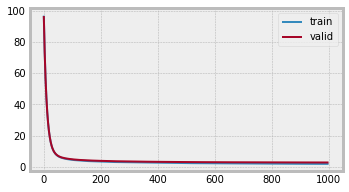

In [4]:
# Training process
import lightgbm as lgb

x_ = lgb.Dataset(x.values, 
                label = y, 
                feature_name = feats_used,
                categorical_feature = feats_cat,
                free_raw_data=False)
xv_ = lgb.Dataset(xv.values, 
                label = yv, 
                feature_name = feats_used,
                categorical_feature = feats_cat,
                free_raw_data=False)
xt_ = lgb.Dataset(xt.values, 
                label = yt, 
                feature_name = feats_used,
                categorical_feature = feats_cat,
                free_raw_data=False)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',

    'learning_rate': 0.05,
    'num_boost_round': 1000,
    'early_stopping_rounds': 50,

    'nthread': -1,
    'verbose': 0,

    # fitting params
    'boost_from_average': True,
    'scale_pos_weight': 1,
    
    'max_bin': 255,
    
    'num_leaves': 63,
    'max_depth': -1,
    'min_child_samples': 20,
    'min_child_weight': 1e-3,
    'min_split_gain': 0,

    'subsample': 1,
    'colsample_bytree': 1,

    'reg_alpha': 0, 
    'reg_lambda': 0,

}

evals_results = {}
model_lgb     = lgb.train(params,
                        x_,
                        valid_sets=[x_, xv_ ], 
                        valid_names=['train', 'valid'], 
                        evals_result=evals_results, 
                        verbose_eval=1000, 
                        feval=None)

p = pd.DataFrame(dict([(k,evals_results[k]['l2']) for k in evals_results])).plot(figsize = (5,3))

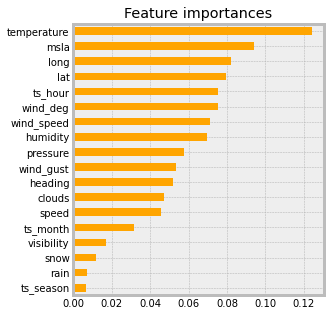

In [5]:
# feature importances
df_imp = pd.Series(model_lgb.feature_importance(), index = feats_used)
df_imp = df_imp/sum(df_imp)
df_imp = df_imp.reset_index()
df_imp.rename(columns={'index':'feat',0:'imp'}, inplace = True)
df_imp = df_imp.sort_values(by = 'imp')
p = df_imp.set_index('feat').imp.plot(kind = 'barh', figsize = (4,5), ylabel = '', color = 'orange', title = 'Feature importances')

### Evaluation

In [6]:
# results
pred = model_lgb.predict(xv)
# pred = pred.clip(min = y.min(), max = y.max())

df_res = df[filt_valid][feats_info]
df_res['pred'] = pred
df_res['mae'] = (df_res[feat_target] - df_res['pred']).abs()
# df_res['mape'] = df_res['mae'] / df_res[feat_target]

df_res[:5]

,timestamp,ts_month,ts_season,pkId,fkLinkSerialId,target_temperature,pred,mae
8135,2022-05-09 00:51:50,5,2,2603788,0X0004BFD036AA,12.00,15.32,3.32
9462,2022-05-09 07:20:59,5,2,2605810,0XB827EBF7489B,15.88,15.00,0.88
9706,2022-05-09 08:03:13,5,2,2606175,0XB827EBF7489B,15.91,14.15,1.76
9813,2022-05-09 08:21:02,5,2,2606332,0XB827EBF7489B,15.84,15.59,0.25
9917,2022-05-09 08:38:33,5,2,2606486,0XB827EBF7489B,14.09,16.27,2.17


In [7]:
df_gr = pd.DataFrame({
    'fkLinkSerialId': ['OVERALL'],
    'mae': [df_res.mean()['mae']],
})

df_gr1 = df_res.groupby(['fkLinkSerialId']).mean()['mae'].reset_index()
df_gr = pd.concat([df_gr, df_gr1])
df_gr

,fkLinkSerialId,mae
0,OVERALL,1.06
0,0X0004BFD036AA,0.96
1,0XB827EB3B7400,1.31
2,0XB827EBF7489B,0.92


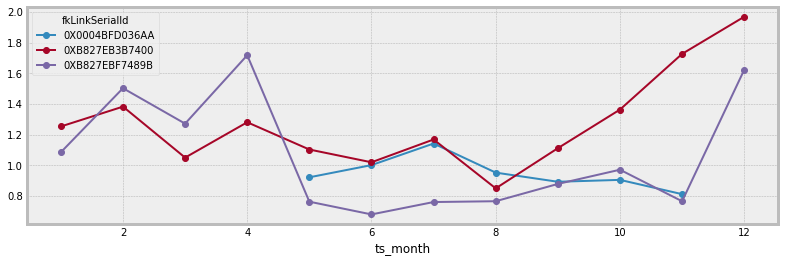

In [8]:
df_gr = df_res.groupby(['ts_month','fkLinkSerialId']).mae.mean().unstack()

_ = df_gr.plot(figsize = (12,4), style = '-o')

### Save predictions

In [9]:
# results
pred = model_lgb.predict(xt)
# pred = pred.clip(min = y.min(), max = y.max())

df_out = df[filt_test][feats_info]
df_out[f'{feat_target}_pred'] = pred

df_out.to_pickle('data/df_out1.pkl')
print(df_out.shape)
df_out[:5]

(323410, 7)


,timestamp,ts_month,ts_season,pkId,fkLinkSerialId,target_temperature,target_temperature_pred
8125,2022-05-09 00:50:19,5,2,2603778,0X0004BFD036AA,NaN,14.59
8127,2022-05-09 00:50:37,5,2,2603780,0X0004BFD036AA,NaN,14.56
8129,2022-05-09 00:50:55,5,2,2603782,0X0004BFD036AA,NaN,14.56
8131,2022-05-09 00:51:14,5,2,2603784,0X0004BFD036AA,NaN,14.48
8133,2022-05-09 00:51:33,5,2,2603786,0X0004BFD036AA,12.00,14.48


### View results

In [10]:
df_out2 = pd.read_pickle('data/df_out2.pkl')

In [11]:
df_out['target_humidity'] = df_out2['target_humidity']
df_out['target_humidity_pred'] = df_out2['target_humidity_pred']

In [12]:
df.groupby(['ts_month','fkLinkSerialId']).size().unstack()

fkLinkSerialId,0X0004BFD036AA,0XB827EB3B7400,0XB827EBF7489B
ts_month,,,
1,"3,531.00","27,721.00","12,677.00"
2,NaN,"17,858.00","5,157.00"
3,NaN,"20,214.00","6,149.00"
4,NaN,"13,100.00","10,611.00"
5,"4,528.00","6,850.00","14,166.00"
6,"2,257.00","8,264.00","27,240.00"
7,"5,833.00","5,936.00","13,080.00"
8,"9,912.00","10,526.00","10,008.00"
9,"7,494.00","5,725.00","7,319.00"


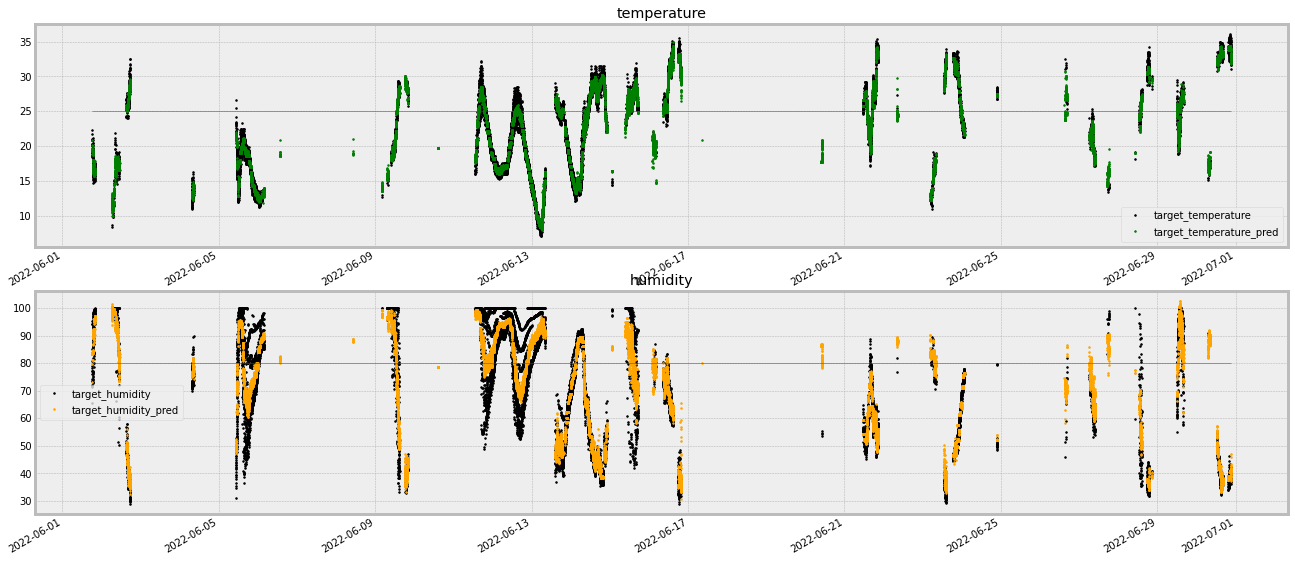

<Figure size 432x288 with 0 Axes>

In [13]:
f1 = df_out.fkLinkSerialId == '0XB827EBF7489B'
f2 = df_out.ts_month == 6

_,ax = plt.subplots(2,1, figsize = (20,10))

feat = 'temperature'
feats = [f'target_{feat}', f'target_{feat}_pred']
x = df_out[f1&f2].set_index('timestamp')[feats]#.resample('1min').median()
_ = x.plot(ax = ax[0], title = feat, xlabel = '', style = '.', markersize = 3, legend = True, color = ['black','green'])
_.hlines(80 if feat == 'humidity' else 25, xmin = x.index.min(), xmax = x.index.max(), color = 'red', linewidth = 0.5)

feat = 'humidity'
feats = [f'target_{feat}', f'target_{feat}_pred']
x = df_out[f1&f2].set_index('timestamp')[feats]#.resample('1min').median()
_ = x.plot(ax = ax[1], title = feat, xlabel = '', style = '.', markersize = 3, legend = True, color = ['black','orange'])
_.hlines(80 if feat == 'humidity' else 25, xmin = x.index.min(), xmax = x.index.max(), color = 'red', linewidth = 0.5)

plt.show()
plt.tight_layout()

In [14]:
x.count()

target_humidity         16398
target_humidity_pred    27240
dtype: int64